In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load the data
data = pd.read_csv('WBD.csv')

data.tail()
# # Set the date as the index


,Date,Close,Open,High,Low,Volume,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
802,10/06/2024,$8.12,$8.20,$8.26,$8.05,"15,619,043",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
803,11/06/2024,$8.04,$8.06,$8.19,$7.97,"20,703,131",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
804,12/06/2024,$7.81,$8.18,$8.27,$7.75,"28,802,980",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805,13/06/2024,$7.29,$7.77,$7.79,$7.27,"48,602,099",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
806,14/06/2024,$7.24,$7.29,$7.39,$7.21,"22,879,072",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data = data[['Date','Close','Open','High','Low','Volume']]

In [4]:
data.columns

Index(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'], dtype='object')

In [5]:
data.head()

,Date,Close,Open,High,Low,Volume
0,01/04/2021,$43.31,$43.98,$44.31,$42.15,"16,364,904"
1,05/04/2021,$41.64,$42.75,$43.40,$40.79,"22,810,790"
2,06/04/2021,$43.38,$41.56,$44.34,$41.56,"23,200,401"
3,07/04/2021,$43.39,$44.67,$45.47,$42.50,"15,198,399"
4,08/04/2021,$41.88,$43.21,$43.62,$41.38,"14,780,462"


In [6]:
# Trim the column names to remove leading and trailing spaces
data.columns = data.columns.str.strip()

In [7]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")
data.set_index('Date', inplace=True)

In [9]:
# Remove currency symbols and spaces, and convert to float
data['Close'] = data['Close'].replace('[\$,]', '', regex=True).astype(float)


In [10]:
# Select the 'Close' price for prediction
closing_prices = data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

# Define the training data size (80% of the data)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [58]:
# Function to create a dataset with look_back steps
def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)



look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [59]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train, Y_train, batch_size=32, epochs=50, validation_data=(X_test, Y_test), callbacks=[early_stop])


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0483 - val_loss: 0.0020
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0041 - val_loss: 2.8357e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018 - val_loss: 1.7572e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015 - val_loss: 2.8604e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014 - val_loss: 1.8552e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013 - val_loss: 2.2300e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014 - val_loss: 1.7252e-04
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 2.8896e-04
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012 - val_loss: 2.4163e-04
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013 - val_loss: 1.4465e-04
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012 - val_loss: 1.7351e-04
Epoch 12/50
20/20 ━━━━━

In [60]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [61]:
# Plotting
train = data[:train_size]
valid = data[train_size:]

valid = valid.iloc[look_back + 1:]

valid['Predictions'] = test_predict

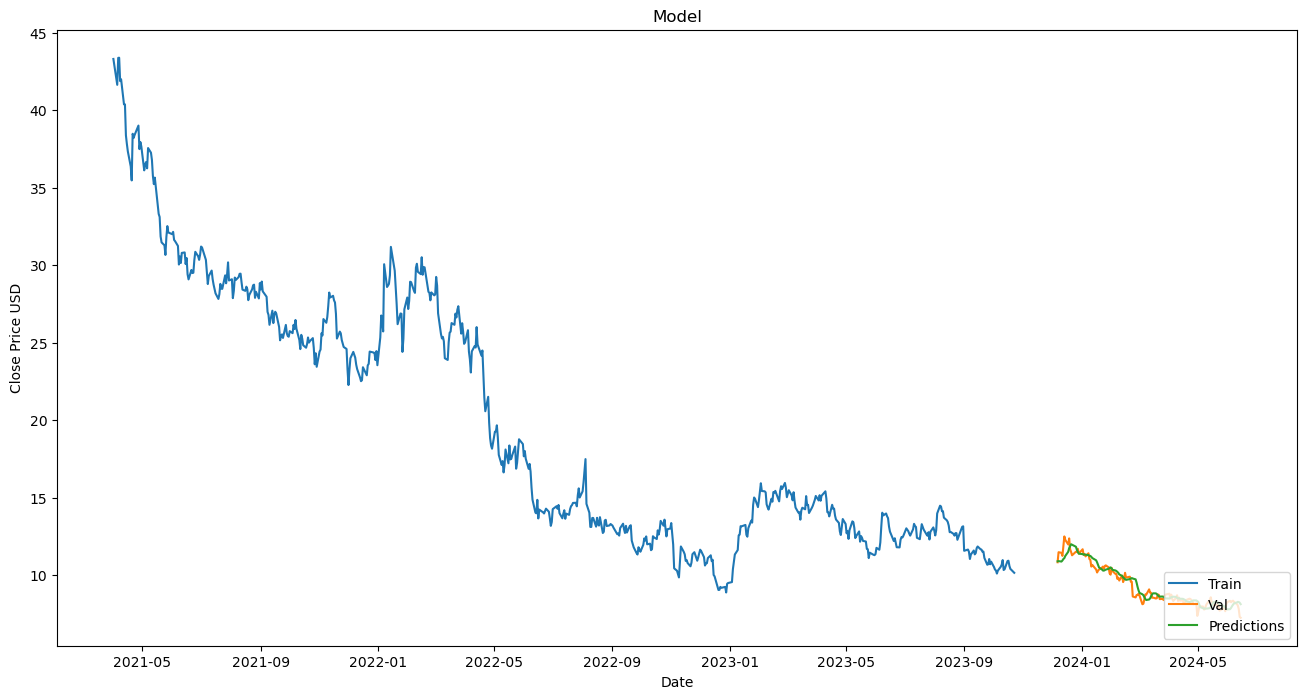

In [62]:

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [63]:

# Function to predict future stock prices
def predict_future(data, model, look_back, days_to_predict):
    future_predictions = []
    last_sequence = data[-look_back:]

    for _ in range(days_to_predict):
        last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1)).reshape(1, look_back, 1)
        next_prediction = model.predict(last_sequence_scaled)
        next_prediction_inversed = scaler.inverse_transform(next_prediction)

        future_predictions.append(next_prediction_inversed[0, 0])
        last_sequence = np.append(last_sequence, next_prediction_inversed)
        last_sequence = last_sequence[1:]

    return future_predictions

In [64]:

# Predict future stock prices for the next 180 days
days_to_predict = 180
future_predictions = predict_future(closing_prices, model, look_back, days_to_predict)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [65]:

# Create a DataFrame for future predictions
last_date = data.index[-1]
future_dates = pd.date_range(last_date, periods=days_to_predict + 1, inclusive='right')
future_df = pd.DataFrame(data={'Date': future_dates, 'Predicted_Close': future_predictions})


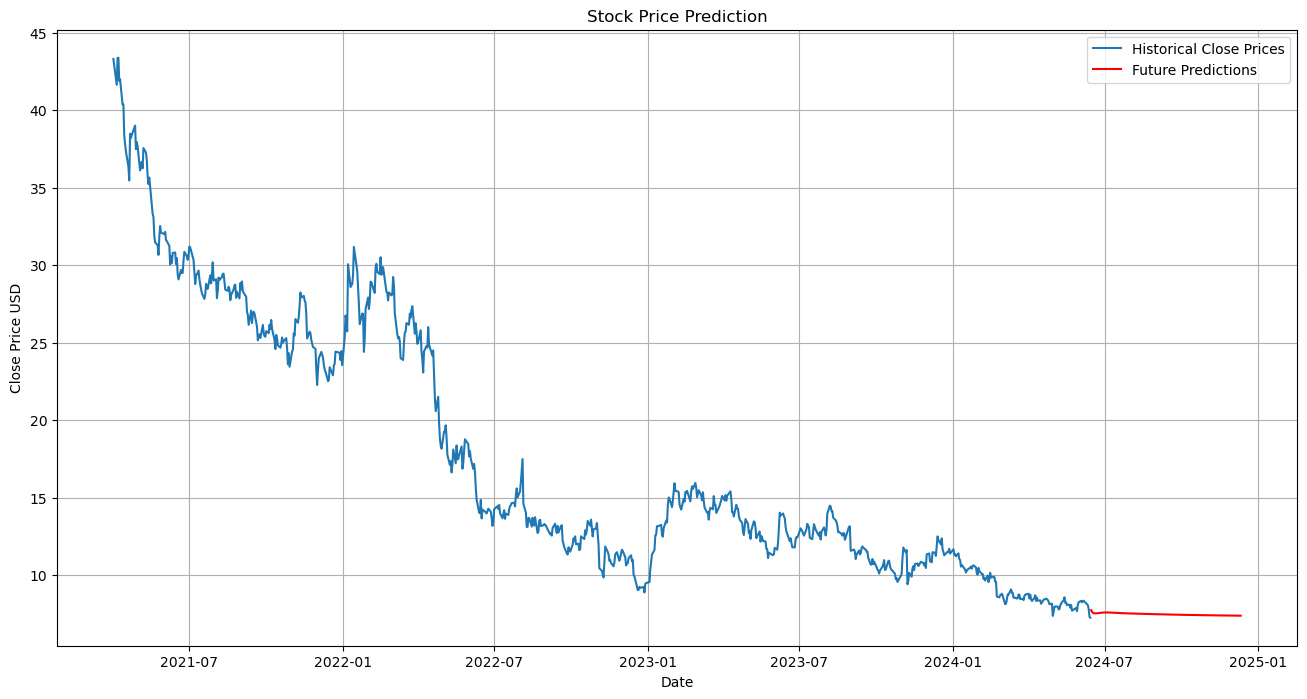

In [66]:

# Visualize future predictions
plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(data['Close'], label='Historical Close Prices')
plt.grid(True)
plt.plot(future_df['Date'], future_df['Predicted_Close'], label='Future Predictions', color='r')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate metrics
mse_train = mean_squared_error(Y_train[0], train_predict[:, 0])
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(Y_train[0], train_predict[:, 0])
r2_train = r2_score(Y_train[0], train_predict[:, 0])

mse_test = mean_squared_error(Y_test[0], test_predict[:, 0])
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(Y_test[0], test_predict[:, 0])
r2_test = r2_score(Y_test[0], test_predict[:, 0])

# Print the results
print(f"Train MSE: {mse_train}")
print(f"Train RMSE: {rmse_train}")
print(f"Train MAE: {mae_train}")
print(f"Train R²: {r2_train}")

print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test R²: {r2_test}")

Train MSE: 1.5879456649044128
Train RMSE: 1.2601371611473144
Train MAE: 0.9510649623251134
Train R²: 0.9610959429173428
Test MSE: 0.4541827569177998
Test RMSE: 0.6739308250242007
Test MAE: 0.6121894857917034
Test R²: -2.658537223860403


In [23]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import numpy as np
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.callbacks import EarlyStopping


look_back_values = [30, 60, 90, 120, 150, 180]
results = []

for look_back in look_back_values:
    # Create datasets
    X_train, Y_train = create_dataset(train_data, look_back)
    X_test, Y_test = create_dataset(test_data, look_back)
    
    # Print shapes before reshaping
    print(f'Look Back: {look_back}')
    print(f'X_train shape: {X_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    
    # Check if there is data to reshape
    if X_train.size == 0 or X_test.size == 0:
        print(f'Skipping look_back={look_back} due to insufficient data.')
        continue
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Build and compile the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Fit the model
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model.fit(X_train, Y_train, batch_size=50, epochs=60, validation_data=(X_test, Y_test), callbacks=[early_stop], verbose=0)
    
    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # Inverse transform the predictions
    train_predict = scaler.inverse_transform(train_predict)
    Y_train = scaler.inverse_transform([Y_train])
    test_predict = scaler.inverse_transform(test_predict)
    Y_test = scaler.inverse_transform([Y_test])
    
    # Calculate metrics
    mse_train = mean_squared_error(Y_train[0], train_predict[:, 0])
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(Y_train[0], train_predict[:, 0])
    r2_train = r2_score(Y_train[0], train_predict[:, 0])
    
    mse_test = mean_squared_error(Y_test[0], test_predict[:, 0])
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(Y_test[0], test_predict[:, 0])
    r2_test = r2_score(Y_test[0], test_predict[:, 0])
    
    results.append({
        'look_back': look_back,
        'mse_train': mse_train,
        'rmse_train': rmse_train,
        'mae_train': mae_train,
        'r2_train': r2_train,
        'mse_test': mse_test,
        'rmse_test': rmse_test,
        'mae_test': mae_test,
        'r2_test': r2_test
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)


Look Back: 30
X_train shape: (614, 30)
X_test shape: (131, 30)
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Look Back: 60
X_train shape: (584, 60)
X_test shape: (101, 60)
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Look Back: 90
X_train shape: (554, 90)
X_test shape: (71, 90)
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Look Back: 120
X_train shape: (524, 120)
X_test shape: (41, 120)
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Look Back: 150
X_train shape: (494, 150)
X_test shape: (11, 150)
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Look Back: 180
X_train shape: (464, 180)
X_test shape: (0,)
Skipping look_back=180 due to insufficient data.
   look_back  mse_train  rmse_train  mae_train  r2_train  mse_test  rmse_test  \
0         30   1.550091    1.245026   0.896672  0.969897  0.248262   0.498259   
1         60   1.4594

In [31]:
results_df

,look_back,mse_train,rmse_train,mae_train,r2_train,mse_test,rmse_test,mae_test,r2_test
0,30,1.550091,1.245026,0.896672,0.969897,0.248262,0.498259,0.380791,0.859992
1,60,1.459478,1.208089,0.886532,0.967947,0.347916,0.589844,0.498471,0.481266
2,90,1.538282,1.240275,0.919321,0.962313,0.336856,0.580393,0.510803,-1.713442
3,120,1.513736,1.230340,0.893656,0.958611,0.238830,0.488702,0.398095,-1.881621
4,150,1.511571,1.229460,0.906017,0.955953,0.301256,0.548868,0.428517,-2.440940
